Данные - https://www.kaggle.com/usdot/flight-delays
Задачи:
1. Найти аэропорт с минимальной задержкой вылета 
2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
3. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)
4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
%%time
df=pd.read_csv('Data/flights.csv', low_memory=False, dtype={'YEAR':str, 'MONTH':str, 'DAY':str, 'DAY_OF_WEEK':str, 'AIRLINE':str})

CPU times: total: 51.3 s
Wall time: 55.4 s


In [53]:
df.shape

(5819079, 13)

In [5]:
pd.set_option('display.max_columns', None)
df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 object 
 1   MONTH                object 
 2   DAY                  object 
 3   DAY_OF_WEEK          object 
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

### Оставим в датафрейме только те столбцы, которые нам нужны для решения поставленных задач

In [9]:
df=df[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED']].copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 object 
 1   MONTH                object 
 2   DAY                  object 
 3   DAY_OF_WEEK          object 
 4   AIRLINE              object 
 5   ORIGIN_AIRPORT       object 
 6   DESTINATION_AIRPORT  object 
 7   DEPARTURE_DELAY      float64
 8   TAXI_OUT             float64
 9   TAXI_IN              float64
 10  ARRIVAL_DELAY        float64
 11  DIVERTED             int64  
 12  CANCELLED            int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 577.1+ MB


### Из проведенного исследования нам известно, что в данных за октябрь месяц обозначения аэропортов в столбцах 'ORIGIN_AIRPORT' и'DESTINATION_AIRPORT' представлены в виде 5-и значного цифрового кода, тогда как в остальной части данных - в виде 3-х значного буквенно-цифрового кода

In [12]:
df.loc[df['MONTH'] == '10' ].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
4385712,2015,10,1,4,AA,14747,11298,10.0,15.0,4.0,-19.0,0,0
4385713,2015,10,1,4,DL,14771,13487,11.0,14.0,7.0,-10.0,0,0
4385714,2015,10,1,4,NK,12889,13487,-5.0,15.0,4.0,-14.0,0,0
4385715,2015,10,1,4,AA,12892,13303,-3.0,28.0,7.0,7.0,0,0
4385716,2015,10,1,4,AA,14771,11057,-2.0,12.0,13.0,-11.0,0,0


In [13]:
df.loc[df['ORIGIN_AIRPORT'].str.len () != 3 ].shape

(486165, 13)

###### По адресу https://github.com/srcole/flightdelay/blob/master/airportcodes/L_AIRPORT_ID.csv получим файл, в котором указано, какому аэропорту соответствует 5-и значный код

In [21]:
df_digit_aircodes=pd.read_csv('Data/L_AIRPORT_ID.csv', low_memory=False, dtype={'Code':str, 'Description':str})

In [22]:
df_digit_aircodes.shape

(6414, 2)

In [23]:
df_digit_aircodes.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


In [24]:
df_digit_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6414 entries, 0 to 6413
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6414 non-null   object
 1   Description  6414 non-null   object
dtypes: object(2)
memory usage: 100.3+ KB


###### По адресу https://github.com/srcole/flightdelay/blob/master/airportcodes/L_AIRPORT.csv получим файл, в котором указано, какому аэропорту соответствует 3-х значный код

In [25]:
df_norm_aircodes=pd.read_csv('Data/L_AIRPORT.csv', low_memory=False)

In [26]:
df_norm_aircodes.shape

(6429, 2)

In [27]:
df_norm_aircodes.head()

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [28]:
df_norm_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6429 entries, 0 to 6428
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6429 non-null   object
 1   Description  6429 non-null   object
dtypes: object(2)
memory usage: 100.6+ KB


###### Смержим обе эти таблицы по столбцу 'Description'

In [29]:
df_merge_aircodes=df_digit_aircodes.merge(df_norm_aircodes, how='inner', on='Description')

In [33]:
df_merge_aircodes.shape

(6443, 3)

In [34]:
df_merge_aircodes.head()

,Code_x,Description,Code_y
0,10001,"Afognak Lake, AK: Afognak Lake Airport",01A
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip",03A
2,10004,"Lik, AK: Lik Mining Camp",04A
3,10005,"Little Squaw, AK: Little Squaw Airport",05A
4,10006,"Kizhuyak, AK: Kizhuyak Bay",06A


In [35]:
df_merge_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6443 entries, 0 to 6442
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code_x       6443 non-null   object
 1   Description  6443 non-null   object
 2   Code_y       6443 non-null   object
dtypes: object(3)
memory usage: 201.3+ KB


In [36]:
df_merge_aircodes.rename(columns = {'Code_x':'Code_id', 'Code_y':'Code'}, inplace = True )

In [41]:
df_merge_aircodes.head()

,Code_id,Description,Code
0,10001,"Afognak Lake, AK: Afognak Lake Airport",01A
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip",03A
2,10004,"Lik, AK: Lik Mining Camp",04A
3,10005,"Little Squaw, AK: Little Squaw Airport",05A
4,10006,"Kizhuyak, AK: Kizhuyak Bay",06A


###### Загрузим файл с данными аэропортов, которые представлены в изучаемом нами датафрейме

In [37]:
df_other_aircodes=pd.read_csv('Data/airports.csv', low_memory=False)

In [38]:
df_other_aircodes.shape

(322, 7)

In [39]:
df_other_aircodes.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [40]:
df_other_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


###### Смержим таблицы df_merge_aircodes и df_other_aircodes, чтобы получить таблицу, в которой будет соответствие используемых в нашем датасете аэропортов по 5-и значному цифровому коду и 3-х значному буквенному

In [42]:
df_aircodes=df_other_aircodes.merge(df_merge_aircodes, how='inner', left_on='IATA_CODE', right_on='Code')

In [43]:
df_aircodes.shape

(323, 10)

In [44]:
df_aircodes.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Code_id,Description,Code
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,10135,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",ABE
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,10136,"Abilene, TX: Abilene Regional",ABI
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,10140,"Albuquerque, NM: Albuquerque International Sun...",ABQ
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,10141,"Aberdeen, SD: Aberdeen Regional",ABR
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,10146,"Albany, GA: Southwest Georgia Regional",ABY


In [45]:
df_aircodes.tail()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Code_id,Description,Code
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,15897,"West Yellowstone, MT: Yellowstone",WYS
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,15919,"Fayetteville, AR: Northwest Arkansas Regional",XNA
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,15991,"Yakutat, AK: Yakutat Airport",YAK
321,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597,13785,"Yuma, AZ: Yuma MCAS/Yuma International",YUM
322,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597,16218,"Yuma, AZ: Yuma MCAS/Yuma International",YUM


###### Выполним замену 5-и значных цифровых кодов на 3-х значные буквенные

In [46]:
n_fl = len(df)
n_fl

5819079

In [47]:
%%time
for i in tqdm(range(n_fl)):
    if len(df['ORIGIN_AIRPORT'].values[i]) !=3:
        df.loc[df['ORIGIN_AIRPORT'] == df['ORIGIN_AIRPORT'].values[i], 'ORIGIN_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == df['ORIGIN_AIRPORT'].values[i]].values[0]
    elif len(df['DESTINATION_AIRPORT'].values[i]) !=3:
        df.loc[df['DESTINATION_AIRPORT'] == df['DESTINATION_AIRPORT'].values[i], 'DESTINATION_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == df['DESTINATION_AIRPORT'].values[i]].values[0]

  0%|          | 0/5819079 [00:00<?, ?it/s]

CPU times: total: 10min 12s
Wall time: 10min 23s


In [48]:
df.loc[df['MONTH'] == '10' ].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
4385712,2015,10,1,4,AA,SEA,DFW,10.0,15.0,4.0,-19.0,0,0
4385713,2015,10,1,4,DL,SFO,MSP,11.0,14.0,7.0,-10.0,0,0
4385714,2015,10,1,4,NK,LAS,MSP,-5.0,15.0,4.0,-14.0,0,0
4385715,2015,10,1,4,AA,LAX,MIA,-3.0,28.0,7.0,7.0,0,0
4385716,2015,10,1,4,AA,SFO,CLT,-2.0,12.0,13.0,-11.0,0,0


In [50]:
df.loc[df['ORIGIN_AIRPORT'].str.len () != 3 ].shape

(0, 13)

In [51]:
df.loc[df['DESTINATION_AIRPORT'].str.len () != 3 ].shape

(0, 13)

In [54]:
df.isna().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
DEPARTURE_DELAY         86153
TAXI_OUT                89047
TAXI_IN                 92513
ARRIVAL_DELAY          105071
DIVERTED                    0
CANCELLED                   0
dtype: int64

## 1. Найти аэропорт с минимальной задержкой вылета

In [59]:
df1 = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].median().sort_values(ascending=True)

In [69]:
df1.head()

ORIGIN_AIRPORT
YAK   -12.0
CDV   -10.0
VEL    -9.0
DIK    -8.0
PIH    -8.0
Name: DEPARTURE_DELAY, dtype: float64

<Axes: ylabel='ORIGIN_AIRPORT'>

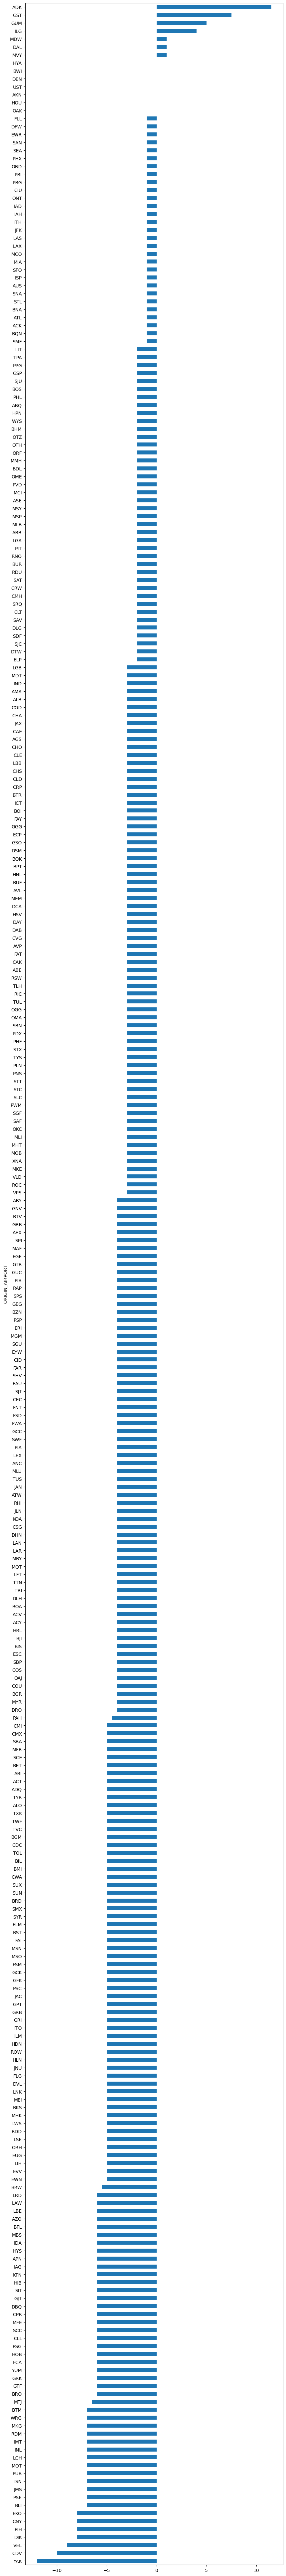

In [60]:
df1.plot(kind='barh', figsize=(10, 100))

In [61]:
df1.index[0]

'YAK'

YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023 - аэрпорт с минимальной задержкой вылета

## 2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807

In [113]:
df2 = df.loc[df['DESTINATION_AIRPORT'] == 'LAX' ]

In [114]:
df2.isna().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
DEPARTURE_DELAY        2229
TAXI_OUT               2320
TAXI_IN                2361
ARRIVAL_DELAY          2652
DIVERTED                  0
CANCELLED                 0
dtype: int64

In [115]:
df2.shape

(212435, 13)

In [116]:
df2.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
101,2015,1,1,4,OO,FAT,LAX,-5.0,33.0,5.0,0.0,0,0
103,2015,1,1,4,OO,AUS,LAX,-3.0,16.0,10.0,-16.0,0,0
129,2015,1,1,4,OO,DEN,LAX,73.0,11.0,10.0,56.0,0,0
131,2015,1,1,4,OO,SMX,LAX,NaN,NaN,NaN,NaN,0,1
156,2015,1,1,4,UA,MCO,LAX,2.0,10.0,23.0,4.0,0,0


In [117]:
df3 = df2.groupby('AIRLINE')['ARRIVAL_DELAY'].median().sort_values(ascending=True)

<Axes: ylabel='AIRLINE'>

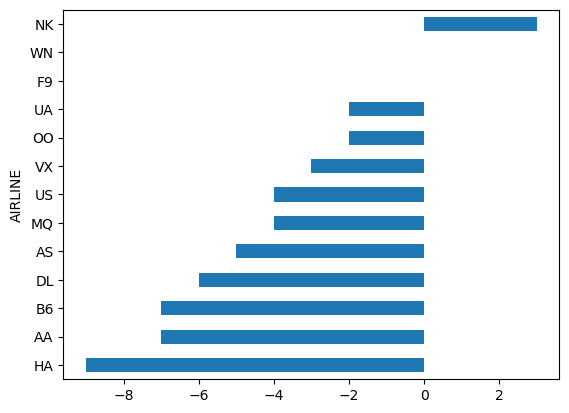

In [118]:
df3.plot(kind='barh')

In [119]:
df3.index[0]

'HA'

HA,Hawaiian Airlines Inc. - самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

## 3. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [120]:
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,ANC,SEA,-11.0,21.0,4.0,-22.0,0,0
1,2015,1,1,4,AA,LAX,PBI,-8.0,12.0,4.0,-9.0,0,0
2,2015,1,1,4,US,SFO,CLT,-2.0,16.0,11.0,5.0,0,0
3,2015,1,1,4,AA,LAX,MIA,-5.0,15.0,8.0,-9.0,0,0
4,2015,1,1,4,AS,SEA,ANC,-1.0,11.0,5.0,-21.0,0,0


Самолеты при одном полете проводят время на рулении два раза:
    1. В аэропорте вылета с момента отправки до момента отрыва колес от взлетной полосы
    2. В аэропорте прилета с момента касания колес до взлетной полосы и до момента подъезда к терминалу.
Посчитаем каждое из этих времен отдельно.

### 3.1 Найдем аэропорт вылета, где самолеты проводят больше всего времени на рулении с момента отправки до момента отрыва колес от взлетной полосы

In [150]:
df4 = df.groupby('ORIGIN_AIRPORT')['TAXI_OUT'].mean().sort_values(ascending=False)

In [151]:
df4.shape

(322,)

<Axes: ylabel='ORIGIN_AIRPORT'>

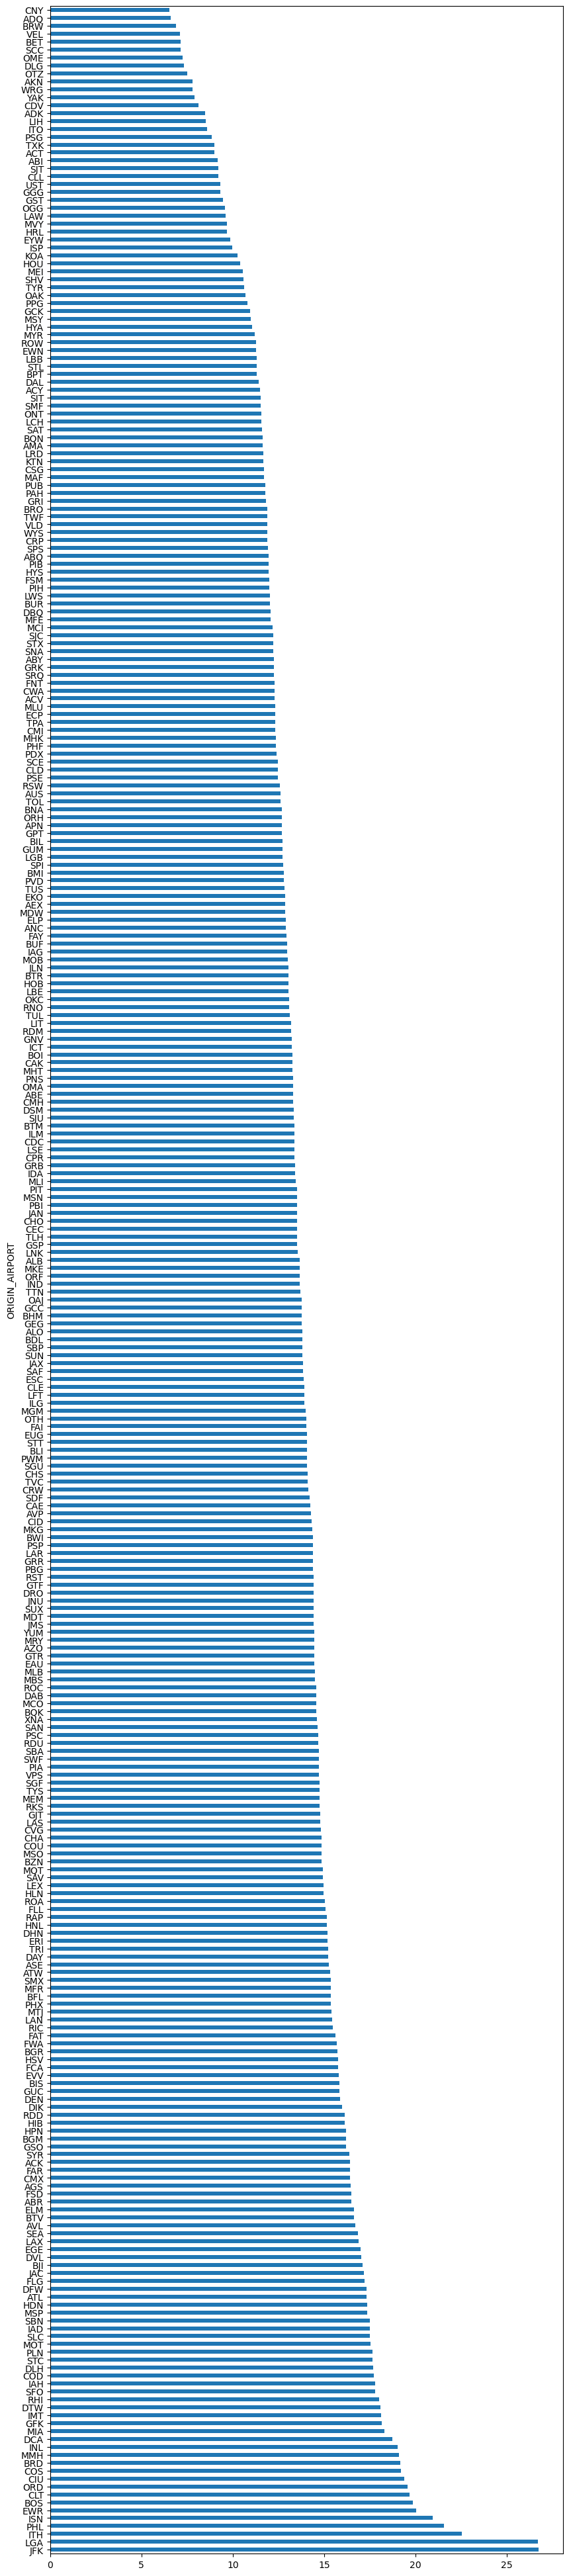

In [152]:
df4.plot(kind='barh', figsize=(10, 50))

In [153]:
df4.head()

ORIGIN_AIRPORT
JFK    26.734585
LGA    26.716354
ITH    22.533333
PHL    21.553135
ISN    20.957190
Name: TAXI_OUT, dtype: float64

In [154]:
df4.index[0]

'JFK'

JFK,John F. Kennedy International AirportВ (New York International Airport),New York,NY,USA,40.63975,-73.77893 - аэропорт вылета, где самолеты проводят больше всего времени на рулении с момента отправки до момента отрыва колес от взлетной полосы

### 3.2 Найдем аэропорт прилета, где самолеты проводят больше всего времени на рулении с момента касания колес до взлетной полосы и до момента подъезда к терминалу.

In [155]:
df5 = df.groupby('DESTINATION_AIRPORT')['TAXI_IN'].mean().sort_values(ascending=False)

In [156]:
df5.shape

(322,)

<Axes: ylabel='DESTINATION_AIRPORT'>

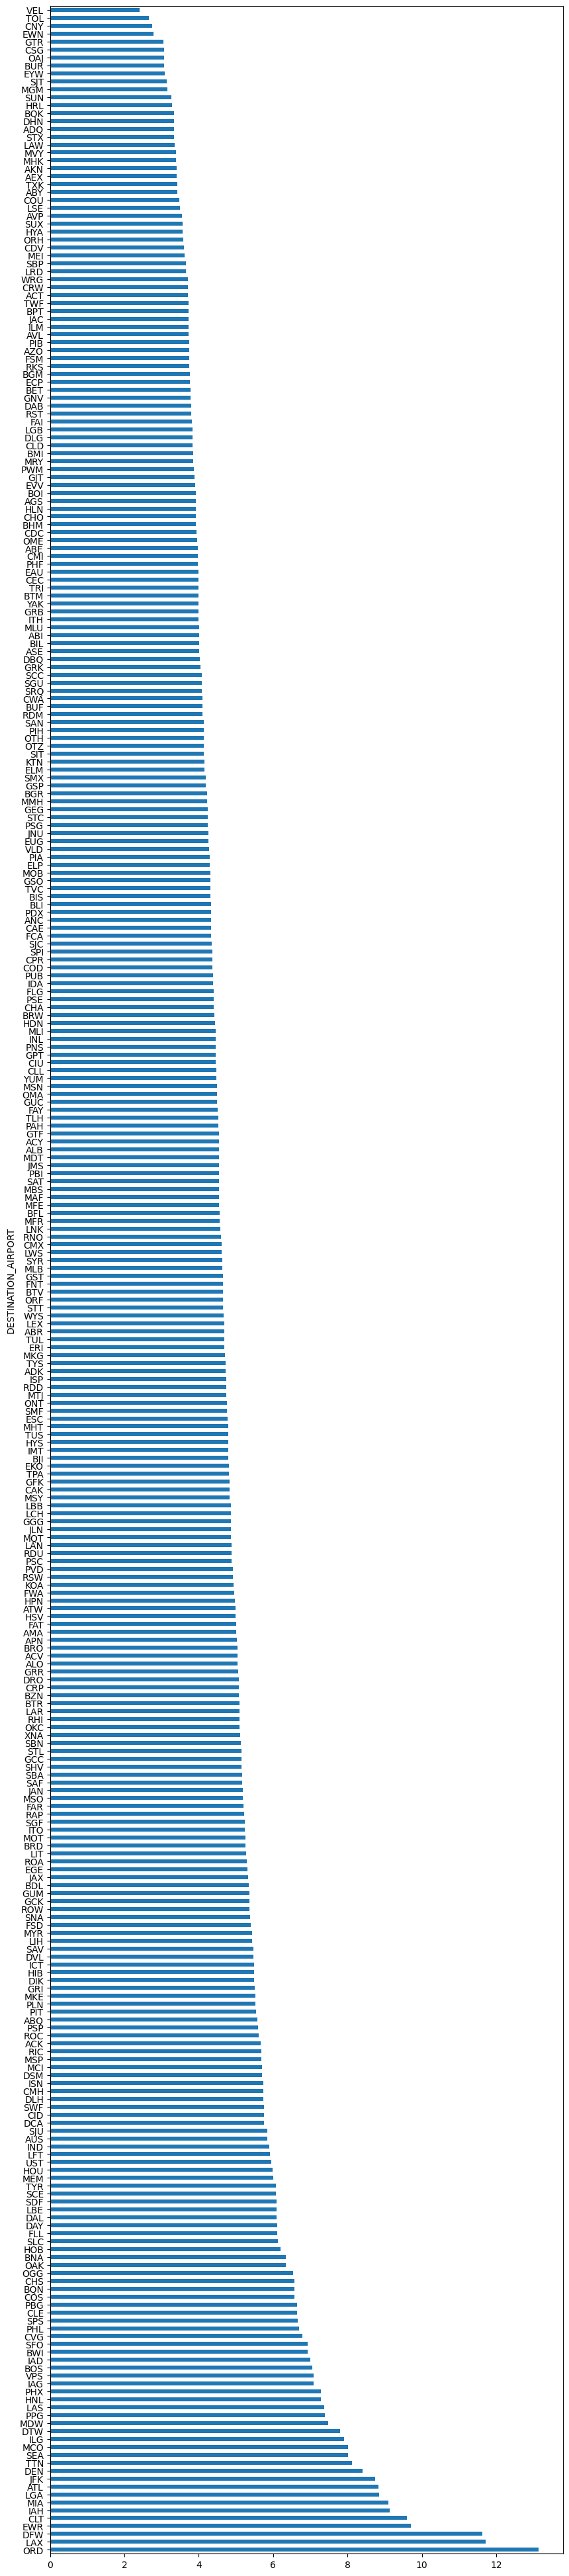

In [157]:
df5.plot(kind='barh', figsize=(10, 50))

In [158]:
df5.index[0]

'ORD'

ORD,Chicago O'Hare International Airport,Chicago,IL,USA,41.97960,-87.90446 - аэропорт прилета, где самолеты проводят больше всего времени на рулении с момента касания колес до взлетной полосы и до момента подъезда к терминалу.

## 4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

In [160]:
# посчитаем количество вылетов из каждого аэропорта
df['ORIGIN_AIRPORT'].value_counts()

ATL    379424
ORD    313536
DFW    260595
DEN    214191
LAX    212401
        ...  
HYA        83
DLG        77
GST        77
AKN        63
ITH        34
Name: ORIGIN_AIRPORT, Length: 322, dtype: int64

###### Возьмем для исследования аэропорт, из которого осуществляется больше всего вылетов - это аэропорт ATL

In [166]:
%%time
df6 = df.loc[df['ORIGIN_AIRPORT'] == 'ATL' ]

CPU times: total: 484 ms
Wall time: 459 ms


In [167]:
df6.shape

(379424, 13)

In [168]:
df6.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
109,2015,1,1,4,EV,ATL,IAD,16.0,9.0,15.0,14.0,0,0
304,2015,1,1,4,F9,ATL,TTN,19.0,11.0,6.0,24.0,0,0
560,2015,1,1,4,AA,ATL,DFW,NaN,NaN,NaN,NaN,0,1
729,2015,1,1,4,DL,ATL,LGA,-1.0,31.0,9.0,8.0,0,0
749,2015,1,1,4,OO,ATL,IAH,-4.0,16.0,10.0,7.0,0,0


###### Решение посредством группировки аэропортов прибытия и вычисления по каждому медианного значения задержки (очень грубая оценка)

In [169]:
df7 = df6.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].median().sort_values(ascending=True)

<Axes: ylabel='DESTINATION_AIRPORT'>

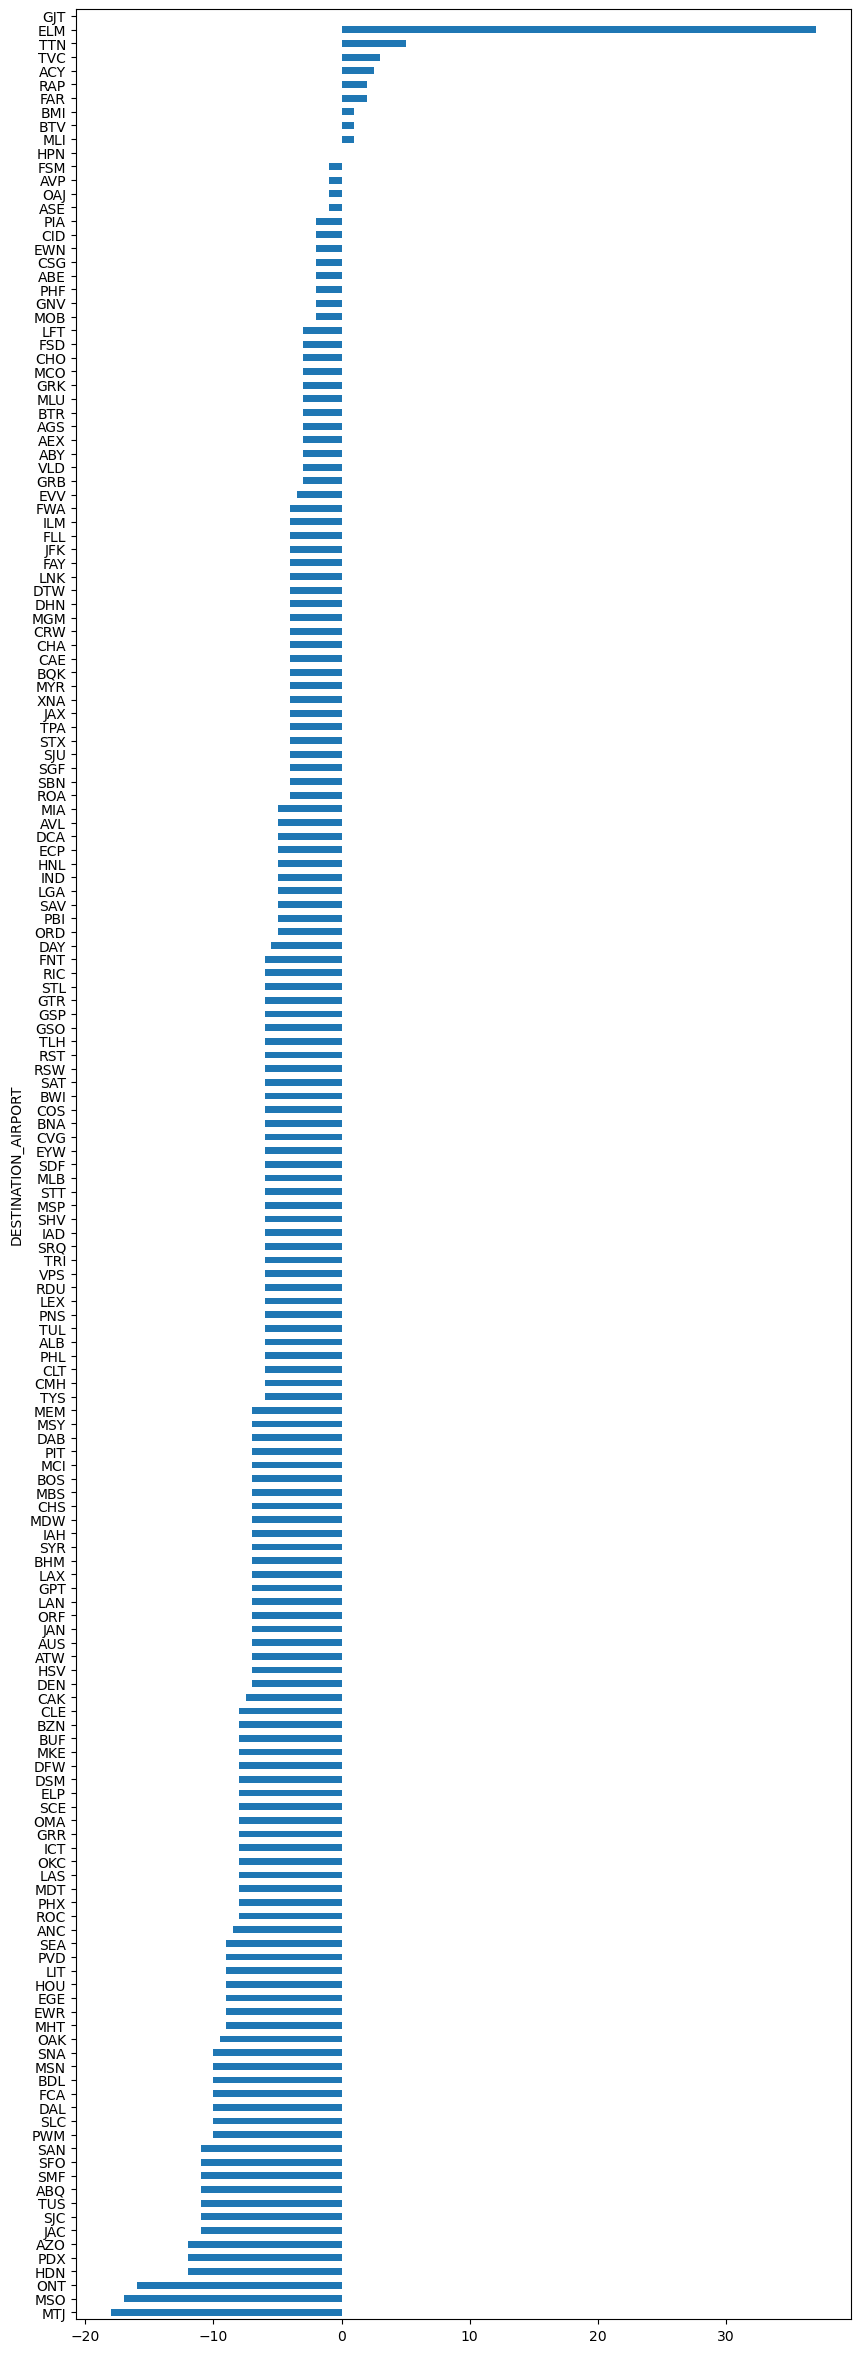

In [170]:
df7.plot(kind='barh', figsize=(10, 30))

In [171]:
df7.index[0], df7.index[1], df7.index[2]

('MTJ', 'MSO', 'ONT')

In [172]:
df7.head()

DESTINATION_AIRPORT
MTJ   -18.0
MSO   -17.0
ONT   -16.0
HDN   -12.0
PDX   -12.0
Name: ARRIVAL_DELAY, dtype: float64

Топ 3 аэропорта прилета с минимальной задержкой прибытия из аэропорта ATL - MTJ, MSO, ONT

###### Решение через построение модели

In [410]:
# для исследования возьмем только те данные, которые нам потребуются
df7=df6[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']].copy()

In [411]:
df7.shape

(379424, 7)

In [412]:
df7.isna().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
ARRIVAL_DELAY          3409
dtype: int64

In [413]:
df7.dropna(inplace=True)

In [414]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376015 entries, 109 to 5818950
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 376015 non-null  object 
 1   MONTH                376015 non-null  object 
 2   DAY                  376015 non-null  object 
 3   DAY_OF_WEEK          376015 non-null  object 
 4   ORIGIN_AIRPORT       376015 non-null  object 
 5   DESTINATION_AIRPORT  376015 non-null  object 
 6   ARRIVAL_DELAY        376015 non-null  float64
dtypes: float64(1), object(6)
memory usage: 23.0+ MB


In [415]:
df7.isna().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
ARRIVAL_DELAY          0
dtype: int64

In [181]:
# посчитаем количество свершившихся вылетов в каждый аэропорт
df7['DESTINATION_AIRPORT'].value_counts()

MCO    8908
LGA    8627
FLL    8059
TPA    7684
DFW    7569
       ... 
RAP      15
MBS      15
ELM      13
LAN      13
ONT       3
Name: DESTINATION_AIRPORT, Length: 168, dtype: int64

###### Для выбора модели попробуем построить модель для аэропорта, в который осуществлено больше всего вылетов - это аэропорт MCO

In [416]:
%%time
df8 = df7.loc[df7['DESTINATION_AIRPORT'] == 'MCO']

CPU times: total: 46.9 ms
Wall time: 48 ms


In [417]:
df8.shape

(8908, 7)

In [418]:
df8.isna().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
ARRIVAL_DELAY          0
dtype: int64

In [419]:
df8['DATE'] = df8['DAY'] + '.' + df8['MONTH'] + '.' + df8['YEAR']

C:\Users\pc\AppData\Local\Temp\ipykernel_6320\3249936649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['DATE'] = df8['DAY'] + '.' + df8['MONTH'] + '.' + df8['YEAR']


In [420]:
df8

,YEAR,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,DATE
815,2015,1,1,4,ATL,MCO,-7.0,1.1.2015
2384,2015,1,1,4,ATL,MCO,5.0,1.1.2015
5124,2015,1,1,4,ATL,MCO,-2.0,1.1.2015
5576,2015,1,1,4,ATL,MCO,-7.0,1.1.2015
6910,2015,1,1,4,ATL,MCO,34.0,1.1.2015
...,...,...,...,...,...,...,...,...
5817068,2015,12,31,4,ATL,MCO,-10.0,31.12.2015
5817777,2015,12,31,4,ATL,MCO,-18.0,31.12.2015
5817899,2015,12,31,4,ATL,MCO,0.0,31.12.2015
5818369,2015,12,31,4,ATL,MCO,-7.0,31.12.2015


In [421]:
df8['DATE'] = pd.to_datetime(df8['DATE'], format = "%d.%m.%Y")

C:\Users\pc\AppData\Local\Temp\ipykernel_6320\1783527831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['DATE'] = pd.to_datetime(df8['DATE'], format = "%d.%m.%Y")


In [422]:
df8['DATE'].value_counts()

2015-12-27    28
2015-12-20    28
2015-12-23    27
2015-12-22    27
2015-12-29    27
              ..
2015-12-24    18
2015-01-24    18
2015-02-24    18
2015-01-01    18
2015-02-25    17
Name: DATE, Length: 365, dtype: int64

In [423]:
df8.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,DATE
815,2015,1,1,4,ATL,MCO,-7.0,2015-01-01
2384,2015,1,1,4,ATL,MCO,5.0,2015-01-01
5124,2015,1,1,4,ATL,MCO,-2.0,2015-01-01
5576,2015,1,1,4,ATL,MCO,-7.0,2015-01-01
6910,2015,1,1,4,ATL,MCO,34.0,2015-01-01


In [424]:
df9 = df8.groupby('DATE', as_index = False)['ARRIVAL_DELAY'].median()

In [425]:
df9 = df9.sort_values(by='DATE').reset_index(drop=True)

In [426]:
df9

,DATE,ARRIVAL_DELAY
0,2015-01-01,-1.5
1,2015-01-02,3.0
2,2015-01-03,3.0
3,2015-01-04,11.0
4,2015-01-05,-3.0
...,...,...
360,2015-12-27,7.0
361,2015-12-28,1.5
362,2015-12-29,14.0
363,2015-12-30,48.0


In [427]:
df9.set_index('DATE', inplace = True)

In [428]:
df9

,ARRIVAL_DELAY
DATE,
2015-01-01,-1.5
2015-01-02,3.0
2015-01-03,3.0
2015-01-04,11.0
2015-01-05,-3.0
...,...
2015-12-27,7.0
2015-12-28,1.5
2015-12-29,14.0


In [405]:
# df9.to_excel("output.xlsx", sheet_name='Sheet_name_1')  

In [429]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ARRIVAL_DELAY  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='DATE'>

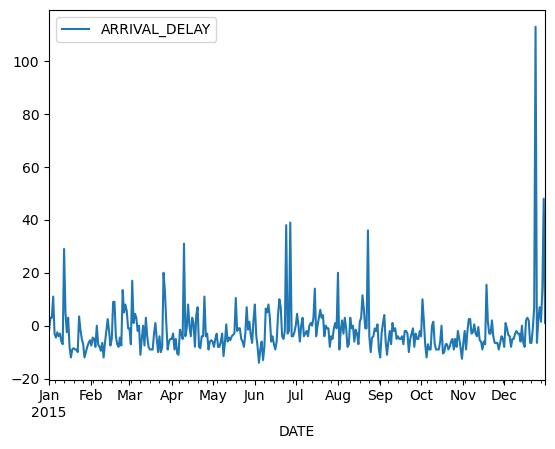

In [430]:
df9.plot()

<Axes: xlabel='DATE'>

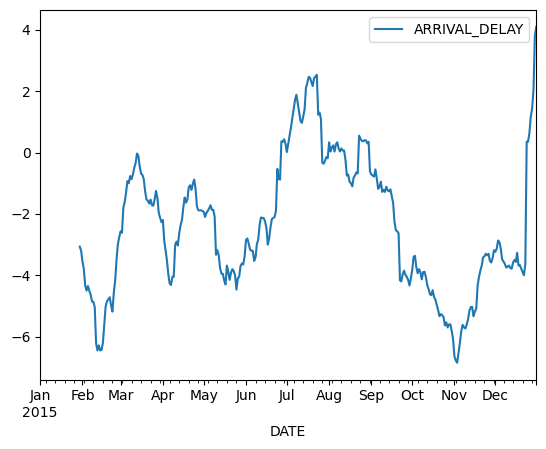

In [431]:
df9.rolling(30).mean().plot()

###### Из графика видно, что наибольшая задержка прибытия самолетов в аэропортах имеет сезонность - наибольшая задержка происходит в дни максимального пассажиропотока - летом и в районе новогодних праздников (25 декабря - Рождество, 31 декабря - Новый Год)

In [432]:
def make_new_features(data, max_lag, roll):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayw'] = data.index.dayofweek
    
    for lag in range(1,max_lag+1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
    
    data['roll_mean'] = data['ARRIVAL_DELAY'].shift().rolling(roll).mean()

In [433]:
df_copy = df9.copy()

In [434]:
df_copy1 = df9.copy()

In [435]:
make_new_features(df_copy,10,3)

In [436]:
df_copy.dropna(inplace=True)

In [437]:
df_copy

,ARRIVAL_DELAY,year,month,day,dayw,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean
DATE,,,,,,,,,,,,,,,,
2015-01-11,-7.0,2015,1,11,6,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,3.0,-1.5,-4.333333
2015-01-12,29.0,2015,1,12,0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,3.0,-5.333333
2015-01-13,5.0,2015,1,13,1,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,5.333333
2015-01-14,-2.5,2015,1,14,2,5.0,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,9.000000
2015-01-15,3.0,2015,1,15,3,-2.5,5.0,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,7.0,2015,12,27,6,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.0,2.0,36.166667
2015-12-28,1.5,2015,12,28,0,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.0,0.833333
2015-12-29,14.0,2015,12,29,1,1.5,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.500000


In [438]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 355 entries, 2015-01-11 to 2015-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ARRIVAL_DELAY  355 non-null    float64
 1   year           355 non-null    int64  
 2   month          355 non-null    int64  
 3   day            355 non-null    int64  
 4   dayw           355 non-null    int64  
 5   lag_1          355 non-null    float64
 6   lag_2          355 non-null    float64
 7   lag_3          355 non-null    float64
 8   lag_4          355 non-null    float64
 9   lag_5          355 non-null    float64
 10  lag_6          355 non-null    float64
 11  lag_7          355 non-null    float64
 12  lag_8          355 non-null    float64
 13  lag_9          355 non-null    float64
 14  lag_10         355 non-null    float64
 15  roll_mean      355 non-null    float64
dtypes: float64(12), int64(4)
memory usage: 47.1 KB


In [439]:
df_copy.to_csv("output1.xlsx")#,
             #sheet_name='Sheet_name_1')  

In [440]:
from sklearn.model_selection import train_test_split

In [441]:
X_train,X_test, y_train, y_test = train_test_split(df_copy.drop('ARRIVAL_DELAY',axis=1),
                                                  df_copy.ARRIVAL_DELAY,
                                                  test_size=0.2,
                                                  random_state=1234556)

In [442]:
from sklearn.linear_model import LinearRegression

In [443]:
lr=LinearRegression()

In [444]:
lr.fit(X_train,y_train)

LinearRegression()

In [445]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [446]:
# без rolling
# MAE = 0.1258586124799548
# MAPE = 0.011990704466406621
print('MAE =', mean_absolute_error(y_test,lr.predict(X_test) ))
print('MAPE =', mean_absolute_percentage_error(y_test,lr.predict(X_test) ))

MAE = 6.025836973716724
MAPE = 1320477842285975.8


Ошибка MAE, а в особенности ошибка MAPE имеют очень большие значения. Очевидно, что линейная регрессия в качестве основы модели для обучения совершенно не подходит.

In [447]:
check_df=pd.DataFrame()
check_df['real'] = y_test
check_df['pred']= lr.predict(X_test)

In [450]:
check_df

,real,pred
DATE,,
2015-09-01,-12.0,-2.112244
2015-06-08,-8.0,-5.592615
2015-07-05,0.0,-6.898690
2015-06-05,-9.0,-6.358316
2015-10-21,-9.0,-2.473180
...,...,...
2015-04-10,31.0,-4.935633
2015-09-05,-6.0,-1.672538
2015-09-13,-5.0,-2.326766


### оценка по предыдущему курсу

In [451]:
def make_new_features1(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayw'] = data.index.dayofweek
    
    for lag in range(1,max_lag+1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

In [452]:
make_new_features1(df_copy1,1)

In [453]:
df_copy1.dropna(inplace=True)

In [454]:
X_train,X_test, y_train, y_test = train_test_split(df_copy1.drop('ARRIVAL_DELAY',axis=1),
                                                  df_copy1.ARRIVAL_DELAY,
                                                  test_size=0.2,
                                                  random_state=1234556)

In [455]:
lr=LinearRegression()
lr.fit(X_train,y_train)
print('MAE =', mean_absolute_error(y_test,lr.predict(X_test) ))
print('MAPE =', mean_absolute_percentage_error(y_test,lr.predict(X_test) ))

MAE = 5.03055562770524
MAPE = 319826942562399.5


# предсказание на 1 января 2016

In [456]:
df_new = pd.DataFrame()
df_new['DATE'] = pd.Series(pd.to_datetime('2016-01-01'))
df_new['ARRIVAL_DELAY'] = 0

In [457]:
df_new

,DATE,ARRIVAL_DELAY
0,2016-01-01,0


In [458]:
forecast_27 = pd.concat([df_copy,df_new],ignore_index=True)

In [459]:
df_copy

,ARRIVAL_DELAY,year,month,day,dayw,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean
DATE,,,,,,,,,,,,,,,,
2015-01-11,-7.0,2015,1,11,6,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,3.0,-1.5,-4.333333
2015-01-12,29.0,2015,1,12,0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,3.0,-5.333333
2015-01-13,5.0,2015,1,13,1,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,3.0,5.333333
2015-01-14,-2.5,2015,1,14,2,5.0,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,11.0,9.000000
2015-01-15,3.0,2015,1,15,3,-2.5,5.0,29.0,-7.0,-6.0,-3.0,-4.0,-2.5,-4.5,-3.0,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,7.0,2015,12,27,6,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.0,2.0,36.166667
2015-12-28,1.5,2015,12,28,0,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.0,0.833333
2015-12-29,14.0,2015,12,29,1,1.5,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.500000


In [460]:
df_new

,DATE,ARRIVAL_DELAY
0,2016-01-01,0


In [461]:
forecast_27.set_index('DATE',inplace = True)

In [462]:
make_new_features(forecast_27,10,3)

In [463]:
forecast_27.tail(1)

,ARRIVAL_DELAY,year,month,day,dayw,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean
DATE,,,,,,,,,,,,,,,,
2016-01-01,0.0,2016.0,1.0,1.0,4.0,1.0,48.0,14.0,1.5,7.0,2.0,-6.5,113.0,7.0,-1.0,21.0


In [464]:
forecast_27

,ARRIVAL_DELAY,year,month,day,dayw,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean
DATE,,,,,,,,,,,,,,,,
NaT,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,29.0,NaN,NaN,NaN,NaN,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,5.0,NaN,NaN,NaN,NaN,29.0,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,-2.5,NaN,NaN,NaN,NaN,5.0,29.0,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000
NaT,3.0,NaN,NaN,NaN,NaN,-2.5,5.0,29.0,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,1.5,NaN,NaN,NaN,NaN,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.0,0.833333
NaT,14.0,NaN,NaN,NaN,NaN,1.5,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,2.0,3.500000
NaT,48.0,NaN,NaN,NaN,NaN,14.0,1.5,7.0,2.0,-6.5,113.0,7.0,-1.0,-6.5,-6.5,7.500000


In [466]:
lr.predict(forecast_27.drop('ARRIVAL_DELAY',axis=1).tail(1))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- lag_10
- lag_2
- lag_3
- lag_4
- lag_5
- ...


## Черновик: 
убираю данные за октябрь, где только цифры

In [93]:
%%time
df1 = df.loc[df['ORIGIN_AIRPORT'].str.len () == 3 ]

CPU times: total: 6.47 s
Wall time: 7.45 s


In [98]:
df1.shape

(5332914, 31)

In [99]:
df1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332914 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 object 
 1   MONTH                object 
 2   DAY                  object 
 3   DAY_OF_WEEK          object 
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023

In [79]:
df2=df.copy()

In [71]:
df2.isna().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
DEPARTURE_DELAY         86153
TAXI_OUT                89047
TAXI_IN                 92513
ARRIVAL_DELAY          105071
DIVERTED                    0
CANCELLED                   0
dtype: int64

In [84]:
df2.dropna(subset=['DEPARTURE_DELAY'], inplace=True)
#df2['DEPARTURE_DELAY'].dropna(subset, inplace=True)

In [85]:
df2.isna().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
DEPARTURE_DELAY            0
TAXI_OUT                2894
TAXI_IN                 6360
ARRIVAL_DELAY          18918
DIVERTED                   0
CANCELLED                  0
dtype: int64

In [86]:
df2.shape

(5732926, 13)

In [87]:
df2.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,ANC,SEA,-11.0,21.0,4.0,-22.0,0,0
1,2015,1,1,4,AA,LAX,PBI,-8.0,12.0,4.0,-9.0,0,0
2,2015,1,1,4,US,SFO,CLT,-2.0,16.0,11.0,5.0,0,0
3,2015,1,1,4,AA,LAX,MIA,-5.0,15.0,8.0,-9.0,0,0
4,2015,1,1,4,AS,SEA,ANC,-1.0,11.0,5.0,-21.0,0,0


In [88]:
df3 = df2.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].median().sort_values(ascending=True)

In [89]:
df3.head()

ORIGIN_AIRPORT
YAK   -12.0
CDV   -10.0
VEL    -9.0
DIK    -8.0
PIH    -8.0
Name: DEPARTURE_DELAY, dtype: float64

In [92]:
df3.tail()

ORIGIN_AIRPORT
MDW     1.0
ILG     4.0
GUM     5.0
GST     7.5
ADK    11.5
Name: DEPARTURE_DELAY, dtype: float64

In [93]:
df1.tail()

ORIGIN_AIRPORT
MDW     1.0
ILG     4.0
GUM     5.0
GST     7.5
ADK    11.5
Name: DEPARTURE_DELAY, dtype: float64

<Axes: ylabel='ORIGIN_AIRPORT'>

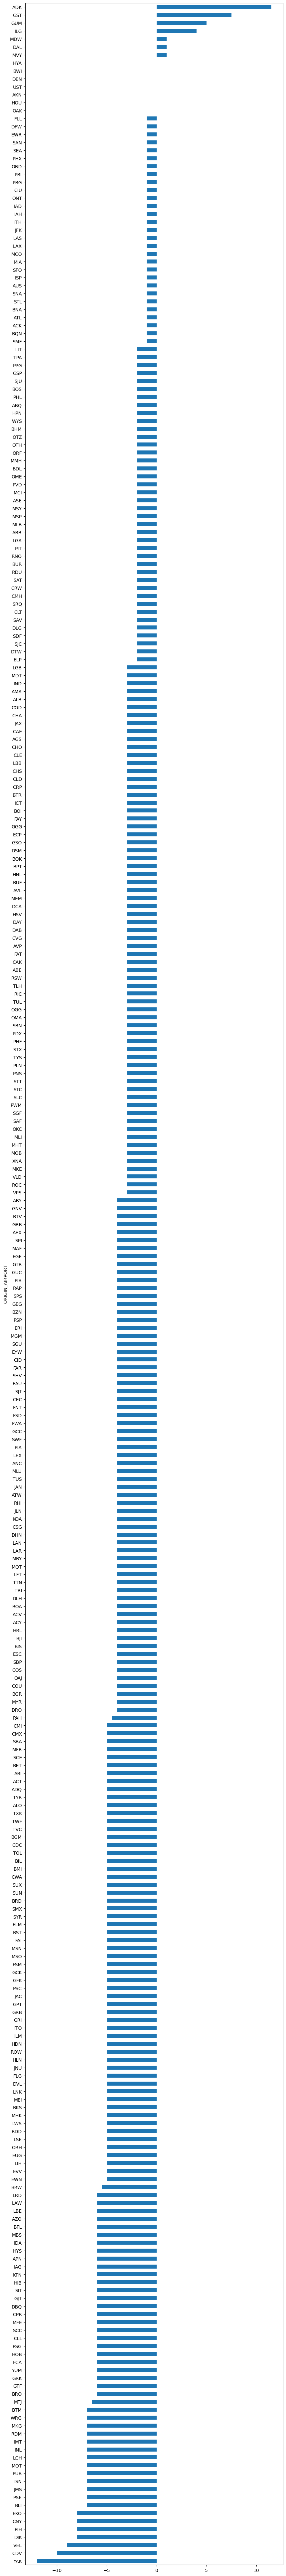

In [90]:
df3.plot(kind='barh', figsize=(10, 100))